In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

print(tf.__version__)

2.2.0


In [2]:
#Loading Mnist Digits Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz") 

In [3]:
data_dir = './Sudoku_Numbers'
digit_list = os.listdir(data_dir)
x_train = x_train.tolist()
y_train = y_train.tolist()


for digit in digit_list:
    digit_path = os.path.join(data_dir,digit)
    for img_name in os.listdir(digit_path):
        img = cv2.imread(os.path.join(digit_path,img_name), 0)
        img = cv2.resize(img, (28,28))
        x_train.append(img)
        y_train.append(int(digit))  


In [4]:
print("No of Total Traning images: ",len(x_train))

No of Total Traning images:  63804


In [5]:
x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')

In [6]:
def remove_zero_digit(img_arr,labels):
    index_val = np.where(labels == 0)
    #index_val = index_val.to_list()
    
    img_arr = np.delete(img_arr,index_val, axis=0)
    label_arr = np.delete(labels, index_val)
    
    return img_arr, label_arr


In [7]:
x_train, y_train = remove_zero_digit(x_train, y_train)
x_test, y_test = remove_zero_digit(x_test, y_test)

In [8]:

_,x_train = cv2.threshold(x_train,127,255,cv2.THRESH_BINARY)
_,x_test = cv2.threshold(x_test,127,255,cv2.THRESH_BINARY)

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

y_train = y_train - 1
y_test = y_test - 1   

In [9]:
# Data Preparation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        #shear_range = 2,
        #brightness_range = [0.9, 1.1]
        )     

datagen.fit(x_train)


In [10]:
#Hyper Parameters Initialization
batch_size = 86
epochs = 10
input_shape= (28,28,1)
train_val_model = True

In [11]:
# CNN Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(9, activation = "softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [12]:
train_data_gen = datagen.flow(x_train, y_train, batch_size)

In [13]:
checkpoint_filepath = './tf_check/checkpoint_val/checkpoint_val'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [14]:
if train_val_model:
    history = model.fit(train_data_gen, 
                        steps_per_epoch=len(x_train) / batch_size, 
                        epochs= epochs, 
                        validation_data= (x_test, y_test), 
                        validation_batch_size= batch_size,
                        callbacks= model_checkpoint_callback)

    model.load_weights(checkpoint_filepath)
    model.save('digit_classifier.h5')

Epoch 1/10
674/673 [==============================] - 148s 220ms/step - loss: 0.3479 - accuracy: 0.8876 - val_loss: 0.0376 - val_accuracy: 0.9861
Epoch 2/10
674/673 [==============================] - 153s 227ms/step - loss: 0.1194 - accuracy: 0.9642 - val_loss: 0.0358 - val_accuracy: 0.9882
Epoch 3/10
674/673 [==============================] - 153s 227ms/step - loss: 0.0958 - accuracy: 0.9721 - val_loss: 0.0444 - val_accuracy: 0.9867
Epoch 4/10
674/673 [==============================] - 154s 229ms/step - loss: 0.0856 - accuracy: 0.9753 - val_loss: 0.0245 - val_accuracy: 0.9922
Epoch 5/10
674/673 [==============================] - 153s 227ms/step - loss: 0.0821 - accuracy: 0.9768 - val_loss: 0.0262 - val_accuracy: 0.9911
Epoch 6/10
674/673 [==============================] - 152s 226ms/step - loss: 0.0822 - accuracy: 0.9768 - val_loss: 0.0236 - val_accuracy: 0.9924
Epoch 7/10
674/673 [==============================] - 153s 227ms/step - loss: 0.0802 - accuracy: 0.9779 - val_loss: 0.0288 -

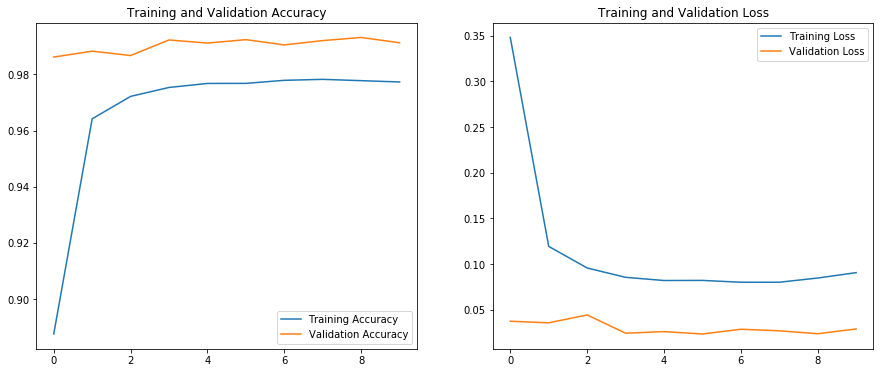

In [15]:
#Visualizing the results of Training
if train_val_model:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('./train_eval.png')
    plt.show()

Predicted Number is:  5


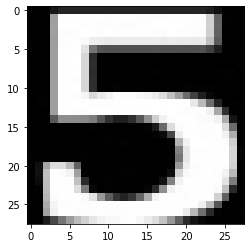

In [19]:
# Testing model with a sample digit data
model = keras.models.load_model('./digit_classifier.h5')
digit = cv2.imread('./Sudoku_Numbers/5/4.png',0)
digit = cv2.resize(digit,(28,28))
plt.imshow(digit, cmap='gray')
print("Predicted Number is: ",np.argmax(model.predict(digit.reshape(-1,28,28,1))[0])+1)